# Create complete network
- get all layers created so far (IRIS, centroids, roads for cars and bikes, public transport layer(s))

- connect centroids to the carbike network: 
    - combine centroids and carbike nodes into one nodes_network dataframe
    - put the combined nodes and the carbike edges into snkit
    - create a base_network with them, create a linked network
    - go back to separate carbike and centroid dataframes as needed



In [131]:
import networkx as nx
import os
os.environ['USE_PYGEOS'] = '1'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import snkit
import snkit.network
crs_fr = 2154 #4326 ?
plt.rcParams['figure.figsize'] = (10, 10)

In [132]:
# Check function
def check_missing_nodes(set11, set12, node_IDs):
    set11 = set(set11)
    set12 = set(set12)
    node_IDs = set(node_IDs)
    IDs_in_edges = set11.union(set12)
    missing = list(sorted(IDs_in_edges - node_IDs))
    added = list(sorted(node_IDs - IDs_in_edges))
    return(missing, added)

In [133]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTION

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

## Get layers

In [134]:
# Get boundary of GPM (for plots)
GPM = gpd.read_file('data/raw/GPM_geometry/GPM.geojson').to_crs(crs_fr)

### Centroids

In [135]:
# Get grid and centroids
grid = pd.read_csv('data/processed/IRIS_GPM.csv').drop(columns = 'geometry')

# turn into geodataframe and separate centroids 
grid['centroid'] = grid['centroid'].apply(shapely.wkt.loads)
centroids = grid.rename(columns = {'centroid':'geometry'}).set_geometry('geometry').set_crs(crs_fr).to_crs(4326)


# Adding necessary attributes for the network
centroids['nodetype'] = 'bike'
centroids['centroid'] = True
centroids['RER'] = False


# Make a new dataframe for the network just in case TODO move to the nextwork building cell 
centroids_network = centroids.to_crs(GPM.crs)
centroids_network['x'] = centroids_network['geometry'].x
centroids_network['y'] = centroids_network['geometry'].y


### roads 

In [136]:
# Get roads (car/bike, nodes/edges)
edges_carbike = pd.read_csv("./data/processed/carbike_edges.csv")
nodes_carbike = pd.read_csv("./data/processed/carbike_nodes.csv")

In [137]:
#--- Getting the nodes ready for the network

# Add attributes
nodes_carbike['centroid'] = False
nodes_carbike['RER'] = False    

# Turn into GeoDataFrame
nodes_carbike["geometry"] = nodes_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike = gpd.GeoDataFrame(nodes_carbike, geometry = 'geometry', crs = 4326).to_crs(GPM.crs)

# Re-create x and y columns
nodes_carbike['x'] = nodes_carbike['geometry'].x
nodes_carbike['y'] = nodes_carbike['geometry'].y


In [138]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

In [139]:
# Turn to GeoDataFrame
edges_carbike["geometry"] = edges_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike = gpd.GeoDataFrame(edges_carbike, geometry = "geometry") 

In [140]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

### Find biggest connected component and only work with that

In [141]:
#--- Checking for connectedness 

# Create Networkx Graph
G1 = nx.from_pandas_edgelist(edges_carbike, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
# G1.add_nodes_from(nodes.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
G1.add_nodes_from(nodes_carbike.loc[:,"osmid"])

# Find disconnected components
S1 = [G1.subgraph(c).copy() for c in nx.weakly_connected_components(G1)] 

#--- Compute some statistics
graph_below_2_nodes = 0
graph_above_2_nodes = 0
big_graph = 0

lengthlist = []
for index in range(len(S1)):
    lengthlist.append(len(S1[index]))
    if len(S1[index]) < 3 :
        graph_below_2_nodes+=1
    elif len(S1[index]) > 100 :
        big_graph +=1
    else:
        graph_above_2_nodes+=1

lengthS1 = 0
for edge in S1[0].edges:
    lengthS1 += edges_carbike.loc[(edges_carbike['x'] == edge[0]) & (edges_carbike['y'] == edge[1]), 'length'].values[0]

# Print the statistics
print("disconnected components with 2 nodes or less ", graph_below_2_nodes)
print("disconnected components with 3 or more nodes, less than 100", graph_above_2_nodes)
print("disconnected components with 100 or more nodes", big_graph)
print("total number of disconnected components", len(S1))
print("Percentage of edges in the largest component", len(S1[0]) / len(edges_carbike) * 100) 
print("Percentage of km of edges in the largest component", lengthS1 / edges_carbike['length'].sum() * 100)

disconnected components with 2 nodes or less  594
disconnected components with 3 or more nodes, less than 100 138
disconnected components with 100 or more nodes 1
total number of disconnected components 733
Percentage of edges in the largest component 55.83971580676443
Percentage of km of edges in the largest component 72.08111674798589


In [142]:
#--- Only work with the largest connected component

# Export the edges of the graph to a pandas dataframe
edges_carbike_connected = nx.to_pandas_edgelist(S1[0], source='x', target='y')
# edges_carbike_connected["geometry"] = edges_carbike_connected.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike_connected = gpd.GeoDataFrame(edges_carbike_connected, geometry = 'geometry', crs = 4326).to_crs(GPM.crs)

# Filter the nodes dataframe to only include the nodes that are in the largest connected component
nodes_carbike_connected = nodes_carbike.loc[nodes_carbike['osmid'].isin(edges_carbike_connected['x']) | nodes_carbike['osmid'].isin(edges_carbike_connected['y'])].to_crs(GPM.crs)

<Axes: >

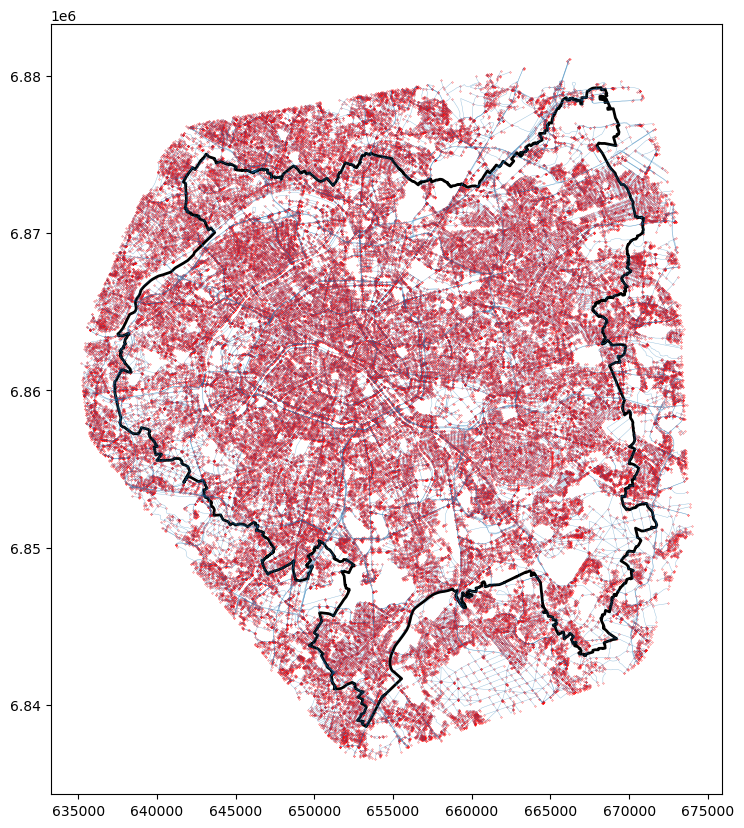

In [143]:
# Plot

ax = plt.axes()
edges_carbike_connected.plot(ax=ax, linewidth = 0.3, alpha = 0.5)
nodes_carbike_connected.plot(ax=ax, markersize = 0.05, facecolor = 'red', alpha = 1)
GPM.plot(ax=ax, facecolor = 'none', linewidth = 2)

### RER and Metro

In [144]:
#--- Get data
RER_stations = pd.read_csv("./data/processed/RER_stations.csv")
RER_lines = pd.read_csv("./data/processed/RER_lines.csv")

In [145]:
#--- Add necessary attributes

# For lines
RER_lines['edgetype'] = 'RER'

# For stations
RER_stations['nodetype'] = 'bike'
RER_stations['centroid'] = False
RER_stations['RER'] = True
RER_stations = RER_stations.rename(columns = {'id': 'osmid'})

In [146]:
#--- turn to GeoDataFrame
RER_stations["geometry"] = RER_stations.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
RER_stations = gpd.GeoDataFrame(RER_stations, geometry = 'geometry')
RER_lines["geometry"] = RER_lines.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
RER_lines = gpd.GeoDataFrame(RER_lines, geometry = 'geometry')


## Connect carbike edges and centroids
A network is created with
- nodes = centroids, RER stops and road intersections
- edges = roads

These edges and nodes are connected by creating an edge between each centroid and its nearest edge.

In [147]:
#--- Create dataframe with all carbike nodes and centroids 
nodes_network = pd.concat([nodes_carbike_connected,centroids_network, RER_stations])

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as RGF93 v1 / Lambert-93 (the single non-null crs provided).
  warnings.warn(


<Axes: >

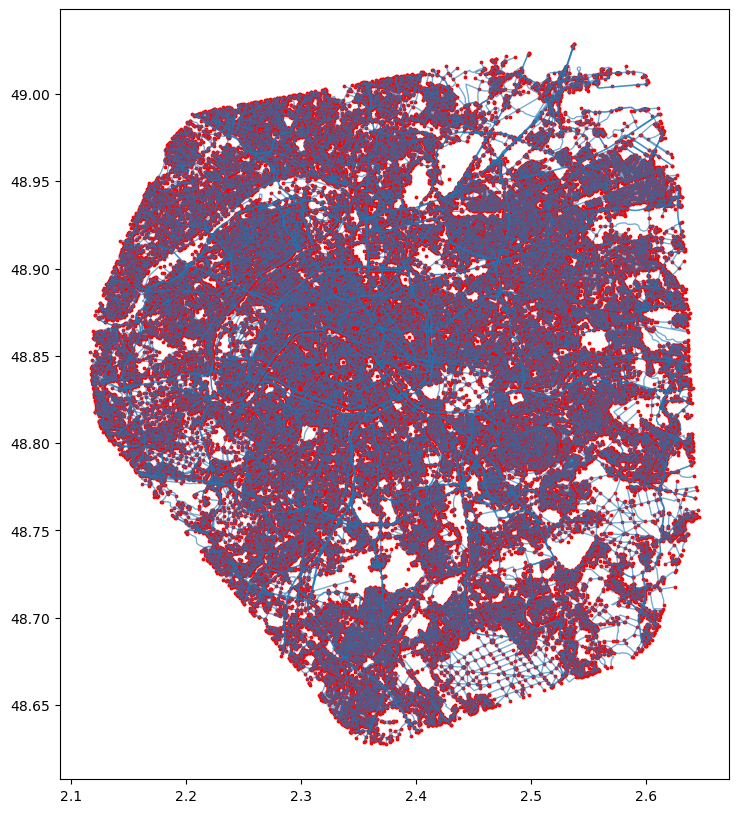

In [153]:
#--- Creating the network 

# Nodes 
nodes = gpd.GeoDataFrame(nodes_network, geometry = "geometry").set_crs(GPM.crs).to_crs(4326)

# Edges
edges = edges_carbike_connected.to_crs(4326)

# Network
base_network = snkit.Network(nodes, edges)

# Plot
ax = plt.axes()
base_network.edges.plot(ax=ax, linewidth = 1, alpha = 0.6)
base_network.nodes.plot(ax=ax, facecolor = 'red', markersize = 3)

In [154]:
# Quick check of consistency
len(check_missing_nodes(base_network.edges['x'], base_network.edges['y'], base_network.nodes['osmid'])[1]) #2996 is good!

2996

In [155]:
%%time 
#--- Link centroids to their nearest edge (takes a while)

linked = snkit.network.link_nodes_to_nearest_edge(base_network) #wth is this warning?
# # plot
# ax = plt.axes()
# linked.edges.plot(ax=ax, linewidth = 1, alpha = 0.5)
# linked.nodes.plot(ax=ax, facecolor = 'red', markersize = 3, alpha = 1)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


CPU times: user 15min 16s, sys: 6.4 s, total: 15min 23s
Wall time: 15min 33s


In [107]:
# create IDs for the new nodes and edges
with_id = snkit.network.add_topology(snkit.network.add_ids(linked))

In [108]:
len(check_missing_nodes(with_id.edges['x'], with_id.edges['y'], with_id.nodes['osmid'])[1])
# TODO recheck this, the number is probs higher
# This should be 5554, as the centroids and new nodes (total: 5554) were not part of the original dataframe with x and y attributes 

5554

In [109]:
# TODO rethink how to separate the different types of nodes
# TODO there should be three dataframes: centroids, RER stops, and new carbike nodes

# Separate old nodes (centroids and carbike nodes) from new ones (intersection between centroid and nearest edge) 
new_carbike_nodes = with_id.nodes[with_id.nodes['nodetype'].isnull()]

# Separate centroids from the other nodes of this network TODO adapt now that RER has been added
centroids_network = with_id.nodes[(with_id.nodes['x'].isnull()) 
                                  & (with_id.nodes['nodetype'].notnull())]

# # Separate RER stations from the other nodes of this network  TODO this is not checked 
# RER_stations_network = with_id.nodes[(with_id.nodes['x'].isnull())
#                                         & (with_id.nodes['nodetype'].isnull())] 

## Post-linking processing

### Nodes
- Make centroids compatible with carbike nodes
- Make the new nodes compatible with the carbike nodes
- Add the new nodes to the carbike nodes
- Process all carbike nodes (old and new)

In [110]:
#--- Process centroids 
#TODO the centroids can only keep their id if they don't conflict with those of the RER stops! 
centroids_network = centroids_network.drop(columns = 'osmid')

# Create the x and y columns
centroids_network = centroids_network.rename(columns = {'id':'osmid'})

# Add attributes 
centroids_network['osmid'] = centroids_network['osmid'].str[5:].astype(int)

centroids_network.tail(1)

,y,x,geometry,nodetype,attr_dict,osmid,centroid,RER
117990,NaN,NaN,POINT (2.27666 48.76719),bike,NaN,117990,True,False


In [111]:
#--- Process new carbike nodes 
new_carbike_nodes = new_carbike_nodes.drop(columns = 'osmid')

# Create the x and y columns
new_carbike_nodes = new_carbike_nodes.rename(columns = {'id':'osmid'})

# Add attributes 
new_carbike_nodes['nodetype'] = 'bike'
new_carbike_nodes['osmid'] = new_carbike_nodes['osmid'].str[5:].astype(int)
new_carbike_nodes['centroid'] = False
new_carbike_nodes['RER'] = False

new_carbike_nodes.tail(1)

,y,x,geometry,nodetype,attr_dict,osmid,centroid,RER
120700,NaN,NaN,POINT (2.27667 48.76703),bike,NaN,120700,False,False


In [ ]:
#--- Process RER nodes
#TODO I need to keep id's that fit the RER edges


In [114]:
#-- Process old carbike nodes
# Add attributes to the old carbike nodes


# nodes_all = nodes_all.drop(columns = 'Unnamed: 0') # TODO still relevant?
nodes_all.head(1)

,osmid,y,x,geometry,nodetype,attr_dict,centroid,RER
0,122926,48.884082,2.463549,POINT (2.46355 48.88408),car,"{'pos': (2.4635493, 48.8840815)}",False,False


In [112]:
# QUICK CHECK: ARE ALL IDs REALLY DIFFERENT FROM EACH OTHER? 
# TODO add RER, ensure that RER id haven't changed 
centroids_minID = int(centroids_network.sort_values(by = 'osmid').head(1).osmid)
centroids_maxID = int(centroids_network.sort_values(by = 'osmid').tail(1).osmid)
new_carbike_nodes_minID = int(new_carbike_nodes.sort_values(by = 'osmid').head(1).osmid)
new_carbike_nodes_maxID = int(new_carbike_nodes.sort_values(by = 'osmid').tail(1).osmid)
nodes_all_minID = int(nodes_all.sort_values(by = 'osmid').head(1).osmid)
nodes_all_maxID = int(nodes_all.sort_values(by = 'osmid').tail(1).osmid)

print(centroids_minID, 
      centroids_maxID, 
      new_carbike_nodes_minID, 
      new_carbike_nodes_maxID,
      nodes_all_minID, 
      nodes_all_maxID) 

115147 117990 117991 120700 122926 10810974432


In [116]:
#--- Combine all nodes 
#TODO add RER
nodes_carbike_complete = pd.concat([nodes_all
, new_carbike_nodes, centroids_network]) 
nodes_carbike_complete = gpd.GeoDataFrame(nodes_carbike_complete, geometry = "geometry")

# Replace or fill in x and y attributes
nodes_carbike_complete = nodes_carbike_complete.to_crs(2154)
nodes_carbike_complete['x'] = nodes_carbike_complete.geometry.apply(lambda p: p.x)
nodes_carbike_complete['y'] = nodes_carbike_complete.geometry.apply(lambda p: p.y)

#--- Dealing with the nodes like we used to (Anastassia) 
# Sort values and drop duplicates 
nodes_carbike_complete = nodes_carbike_complete.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
# MOD-Stpehan : split geometry into lat and lon
# MOD: added centroid and RER as attributes 
nodes_carbike_complete["attr_dict"] = nodes_carbike_complete.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER),
                                                                  axis = 1) 

nodes_carbike_complete["osmid"] = nodes_carbike_complete["osmid"].astype(int)
nodes_carbike_complete.head(1)


,osmid,y,x,geometry,nodetype,attr_dict,centroid,RER
0,115147,6.863494e+06,654127.131043,POINT (654127.131 6863493.518),bike,"{'lat': 654127.1310431994, 'lon': 6863493.5178...",True,False


In [117]:
# QUICK CHECKS 
# TODO recheck the numbers
# This should be 120700, or the max id of the centroids and new nodes together since they were never given x and y attributes 
print(max(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_complete['osmid'])[1])) 

# This should be nan
print(min(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_complete['osmid'])[0])) 

# This should be 5554, same reasoning as above
print(len(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_complete['osmid'])[1])) 


120700
nan
5554


### Edges
- Make new edges compatible with the old ones
    - some new edges connect with a node from the carbike network using the ID given by linked_network instead of the original osmID -> change these IDs into their osmIDs AND update this info in the edges df
    - These IDs are already absent from the nodes_carbike_complete df since it is based on the old nodes_all df and the new_nodes and centroids dfs

In [118]:
#--- Make with_id.nodes and edges workable
n = 5
edges_with_id = with_id.edges
edges_with_id['from_id'] = edges_with_id['from_id'].str[5:].astype(int)
edges_with_id['to_id'] = edges_with_id['to_id'].str[5:].astype(int)
edges_with_id['id'] = edges_with_id['id'].str[5:].astype(int)

#TODO recheck numbers
print(max(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_complete['osmid'])[0]) )
# highest missing id in edges should be BELOW all of those in the nodes dataframe (i.e 115147) TODO update after RER

print(min(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_complete['osmid'])[1]) )
# lowest missing ID in nodes should be the lowest original osmid (i.e 122926), need to overwrite the nodes id in edges with their new value # TODO update after RER

115146
122926


In [119]:
#--- Replacing new IDs with osmIDs where necessary
# TODO adapt due to RER cell
# TODO add RER cell 

# Create a dictionary of ID to osmID
oldnodes_in_newedges = with_id.nodes.loc[(with_id.nodes['osmid'].notnull())] # They have an non-null osmID (the new nodes don't have one)
oldnodes_in_newedges['osmid'] = oldnodes_in_newedges['osmid'].astype(int)
oldnodes_in_newedges['id'] = oldnodes_in_newedges['id'].str[5:].astype(int)
oldnodes_in_newedges.set_index('id',inplace=True)
id_osmid_dict = oldnodes_in_newedges.to_dict()['osmid']

# Replace IDs with osmIDs in the edges dataframe
edges_with_id['from_id'] = edges_with_id['from_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)
edges_with_id['to_id'] = edges_with_id['to_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)



/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [120]:
#--- Fill in the edgetype for the new edges 
# Create a dictionary of nodeID to nodetype
nodes_type_df = nodes_carbike_complete
nodes_type_dict = nodes_type_df.reset_index()
nodes_type_dict = nodes_type_dict.set_index('osmid').to_dict()['nodetype']


# Find the correct column indexes to work with
index_edgetype = edges_with_id.columns.get_loc("edgetype")
index_fromID = edges_with_id.columns.get_loc("from_id")
index_toID = edges_with_id.columns.get_loc("to_id")
index_x = edges_with_id.columns.get_loc("x")
index_y = edges_with_id.columns.get_loc("y")
index_edge_id = edges_with_id.columns.get_loc("edge_id")


# Fill in the edgetype 
# With the nodetype of the from_id and to_id if it is the same
# With 'car' if it is different
for i in range(len(edges_with_id)):
    if pd.isnull(edges_with_id.iloc[i,index_edgetype]):
        if nodes_type_dict[edges_with_id.iloc[i,index_fromID]] == nodes_type_dict[edges_with_id.iloc[i,index_toID]]:
            edges_with_id.iloc[i,index_edgetype] = nodes_type_dict[edges_with_id.iloc[i,index_toID]]
        else:
            edges_with_id.iloc[i,index_edgetype] = 'car'


In [124]:
#--- Fill in the x and y columns where they are NaN
# With x = from_id and y = to_id
for i in range(len(edges_with_id)):
      if pd.isnull(edges_with_id.iloc[i,index_x]):
         edges_with_id.iloc[i,index_x] = edges_with_id.iloc[i,index_fromID]
         edges_with_id.iloc[i,index_y] = edges_with_id.iloc[i,index_toID]
edges_with_id['x'] = edges_with_id['x'].astype(int)
edges_with_id['y'] = edges_with_id['y'].astype(int)


# #--- Fill in the edge_id column where it is NaN with [from_id, to_id]
edges_with_id['edge_id'] = edges_with_id.apply(lambda row: str([row["x"], row["y"]]), axis = 1)
# Convert edges_with_id.edge_id from string to list of int
edges_with_id['edge_id'] = edges_with_id['edge_id'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
# TODO THIS IS STILL A LIST OF STRINGS, NOT A LIST OF INTS!!!

#--- Drop unnecessary columns
edges_with_id = edges_with_id.drop(['from_id','to_id', 'id', 'key', 'osmid'], axis = 1)

#--- Fill in the 'length' column
edges_with_id = edges_with_id.set_crs(4326).to_crs(2154)
edges_with_id['length'] = edges_with_id.length

#--- Drop duplicates
edges_with_id = edges_with_id.drop_duplicates(subset = ["x", "y"], keep = "first", ignore_index = True)

edges_with_id.head(1)


,edgetype,length,geometry,edge_id,x,y
0,car,1622.179102,"LINESTRING (660659.668 6865029.767, 660572.244...","[122926, 318399738]",122926,318399738


In [129]:
# Add travel time column

# Define speeds in meters per minute
speed_dict = {'bike' : 250,
              'car' : 83.3,
              'RER' : 1000}

edges_with_id['weight'] = edges_with_id.apply(lambda row: row['length'] / speed_dict[row['edgetype']], axis = 1)

edges_with_id


,edgetype,length,geometry,edge_id,x,y,weight
0,car,1622.179102,"LINESTRING (660659.668 6865029.767, 660572.244...","[122926, 318399738]",122926,318399738,19.473939
1,car,125.163134,"LINESTRING (660659.668 6865029.767, 660673.284...","[122926, 85245811]",122926,85245811,1.502559
2,car,201.314921,"LINESTRING (660659.668 6865029.767, 660749.897...","[122926, 289232660]",122926,289232660,2.416746
3,car,1005.671376,"LINESTRING (660565.447 6867454.300, 660594.138...","[122935, 413741124]",122935,413741124,12.072886
4,car,939.005591,"LINESTRING (661367.217 6865800.872, 661349.281...","[122935, 85245595]",122935,85245595,11.272576
...,...,...,...,...,...,...,...
168304,car,23.673718,"LINESTRING (648487.510 6858522.990, 648486.160...","[117986, 605558404]",117986,605558404,0.284198
168305,bike,9.928463,"LINESTRING (660292.952 6869626.080, 660297.935...","[117987, 120697]",117987,120697,0.039714
168306,bike,0.564146,"LINESTRING (649682.463 6855173.874, 649682.515...","[117988, 120698]",117988,120698,0.002257
168307,bike,331.832836,"LINESTRING (655237.275 6846720.847, 655207.853...","[117989, 120699]",117989,120699,1.327331


In [122]:
# There shouldn't be any NaNs anymore
edges_with_id.isnull().sum()

edgetype    0
length      0
geometry    0
edge_id     0
x           0
y           0
dtype: int64

In [ ]:
print(check_missing_nodes(edges_with_id['x'], edges_with_id['y'], nodes_carbike_complete['osmid']))
# First list empty:all nodes in nodes_carbike_complete are present in some edge of edges_with_id
# Second list empty:  all nodes in edges_with_id exist in nodes_carbike_complete

([], [])


## Creating the NetworkX Graph

In [125]:
nodes_carbike_complete.head(1)

,osmid,y,x,geometry,nodetype,attr_dict,centroid,RER
0,115147,6.863494e+06,654127.131043,POINT (654127.131 6863493.518),bike,"{'lat': 654127.1310431994, 'lon': 6863493.5178...",True,False


In [126]:
edges_with_id.head(1)

,edgetype,length,geometry,edge_id,x,y
0,car,1622.179102,"LINESTRING (660659.668 6865029.767, 660572.244...","[122926, 318399738]",122926,318399738


In [33]:
#--- Create Graph with all nodes and edges with ahve
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
G.add_nodes_from(nodes_carbike_complete.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

#--- Check if all nodes and edges are present
# Both should be 0
print(len(G.nodes()) - len(nodes_carbike_complete))
print(len(G.edges()) - len(edges_with_id)) 


0
0


In [34]:
#--- Create "bikeable" network B (Anastassia)
B = G.copy()
bikeable_nodes = [node for node in B.nodes if B.nodes[node]["nodetype"]!="car"]
B_noncar_induced = B.subgraph(bikeable_nodes).copy() 

# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
banw = B_noncar_induced.copy()
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="car"])

#--- Check if all nodes and edges are present
# Both should be 0
print(len(banw.nodes()) - len(nodes_carbike_complete.loc[nodes_carbike_complete['nodetype'] == 'bike']))
print(len(banw.edges()) - len(edges_with_id.loc[edges_with_id['edgetype'] == 'bike'])) 


In [68]:
#--- Routing between centroids

# Pick two random nodes with centroid = True
start_node = nodes_carbike_complete.loc[nodes_carbike_complete['centroid'] == True].sample(1)
end_node = nodes_carbike_complete.loc[nodes_carbike_complete['centroid'] == True].sample(1)

#IF FALSE YOU HAVE A PROBLEM
# Check if they are connected on the bike network
print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))
# Check if they are connected on the car network
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))

#G.edges[122926, 318399738]

False
False


In [ ]:
# ADD RER
# Is this all still working and making sense?
# Do I still have a fully connected graph at the end? 

## What's next?

BUILDING THE SKELETAL NETWORK --April--
- ~~finish cleaning up edges/nodes for carbike after linking them with the centroids~~
    - ~~edges need~~
        - ~~to have info on the travel mode (car/bike/public transport)~~
        - ~~weight = travel time for the relevant transport mode~~
        - ~~origin and destination node IDs~~
- ~~Figure out how to export the whole thing to NetworkX~~
- ~~create separate subnetworks for car and bike travel~~
- 3: add restriction on how to travel (either only bike or only car, not both) (BY FRIDAY 28/4)

- 2: add RER (BY TUESDAY 25/04)

- send visuals and stuff to Anastassia and Trivik (BY MAY 1)

GOAL: I can pick two centroids and find the shortest path, which is all walk, all bike, or walk/bike to station then walk 


SOCIAL STUFF -- second midterm (May 22nd)--
- define needed data for POIs and people 
- find data for POIs and people
- add all of it to centroids
- find/define OD matrix
GOAL: I can pick one pop and one POI and find the shortest path

OPTIMISATION STUFF (June)
- find algorithm
- modify network to allow for optimisation
- do whatever it takes to get stuff to run
- first results!! 
